# Figures - Clustering

Plot clustering results of basic clustering approach

In [1]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import datetime

In [2]:
# Loading filtered dataset
filename = 'data/MFI_with_RS_new_filtering.csv'
df_filtered = pd.read_csv(filename, encoding = "latin").set_index('RSNR', drop=False)

In [3]:
# We need to standardize the way in which we compile the time series of each patient:
# For missing Abs, we should add a 499,499,... or a NaN,NaN,... time series
ALL_ABS_TYP1 = df_filtered[df_filtered['TYP']=='Lumi-Single-Klasse1']['I_NAM'].unique()
ALL_ABS_TYP2 = df_filtered[df_filtered['TYP']=='Lumi-Single-Klasse2']['I_NAM'].unique()
ALL_ABS = df_filtered['I_NAM'].unique()

def get_time_series(df, Ab_id, dummy_value_inter=499, dummy_value_whole=np.nan):    
    # Transform into datetime objects for sorting
    dates = [datetime.datetime.strptime(x, '%d.%m.%Y') for x in list(df['IL_DAT'].unique())]
    dates = sorted(dates)
    
    # Check if there is any value matching the ab id
    values = []
    if Ab_id in df['I_NAM'].values:
        for date in dates:
            str_date = datetime.datetime.strftime(date, '%d.%m.%Y')
            df_date = df[df['IL_DAT']==str_date]
            if Ab_id in df_date['I_NAM'].values:
                val = df_date[df_date['I_NAM'] == Ab_id]['I_VAL'].values
                values.append(float(val[0]))
            else:
                values.append(dummy_value_inter)
        return np.asarray(values), dates
    else:
        return dummy_value_whole*np.ones(len(dates)), dates

def get_evolution_df(df, complete=False, analysis_type='1'):
    evo_df = pd.DataFrame()
    if complete:
        # Need to check if we only consider type1 or type2 or both...
        if analysis_type == '1':
            # CAREFUL: There is no automatic check to verify...
            list_abs = ALL_ABS_TYP1 # Generate a ts for every ab
        elif analysis_type == '2':
            list_abs = ALL_ABS_TYP2
        else:
            list_abs = ALL_ABS
    else:
        list_abs = list(df['I_NAM'].unique()) 
    for ab_id in list_abs:
        ts, dates = get_time_series(df[df['TYP']=='Lumi-Single-Klasse'+analysis_type], ab_id, dummy_value_inter=499, dummy_value_whole=499)
        evo_df[ab_id] = ts
    dates = pd.DatetimeIndex(dates)
    evo_df = evo_df.set_index(dates)
    return evo_df

In [4]:
# Unfortunately patients have non-matching time series for the 2 classes of assays
# hence we will have two sets of time-series for each patients.
def filter_patients(df_in, analysis_type="1"):
    df_filtered_typ = df_in[df_in['TYP']=='Lumi-Single-Klasse'+ analysis_type]
    # Let's only keep patients with at least 2 measurements
    df_n = df_filtered_typ.groupby('RSNR')['IL_DAT'].nunique()
    print('{} patients need to be excluded as they only have one date of measurements.'.format((df_n==1).sum()))
    df_filtered_typ = df_filtered_typ.set_index('RSNR', drop=False)[df_n>1]
    return df_filtered_typ

In [5]:
# The basic idea is to extract moments of each of the timeseries and cluster them using a classical clustering method
# (K means or DBSCAN for outliers)
# First, we extract the moments for individual ts
# Gather the signal differences and average them for all single measurements
tdifs = []
valdifs = []
ts_dict = dict()
ALL_ABS_TYP1=[x for x in ALL_ABS_TYP1 if x==x]
df_filtered_typ1 = filter_patients(df_filtered)

for rs in df_filtered_typ1['RSNR'].unique():
    a = get_evolution_df(df_filtered_typ1.loc[rs], complete=True, analysis_type='1')
    try:
        a = a.drop(np.nan, axis=1)
    except:
        pass
    ts_dict[rs]=a

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 'RSNR' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


17 patients need to be excluded as they only have one date of measurements.


In [6]:
ts_dict_2 = dict()
ALL_ABS_TYP2=[x for x in ALL_ABS_TYP2 if x==x]
df_filtered_typ2 = filter_patients(df_filtered, analysis_type='2')
for rs in df_filtered_typ2['RSNR'].unique():
    a = get_evolution_df(df_filtered_typ2.loc[rs], complete=True, analysis_type='2')
    try:
        a = a.drop(np.nan, axis=1)
    except:
        pass
    ts_dict_2[rs]=a

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 'RSNR' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


20 patients need to be excluded as they only have one date of measurements.


In [7]:
# Get one vector for each patient
def get_ts_summary(df_ts):
    # Get the mean and std of each AB MFI, the mean and std of the ratio of MFI change over time change,
    # Total time, total num of measurements, mean and std of time between measurements
    # 0. transform to avoid nans
    df_ts = df_ts.replace(np.nan, 499)
    # 1. Mean and std of ts
    m = np.mean(df_ts.as_matrix(), axis=0)
    s = np.std(df_ts.as_matrix(), axis=0)
    # 2. mean and std of valdif/tdif
    tdif = np.array([float(x.days) for x in df_ts.index[1:]-df_ts.index[:-1]]).reshape(-1,1)
    valdif = df_ts.as_matrix()[1:,:]-df_ts.as_matrix()[:-1,:]
    if np.isnan(df_ts.as_matrix()).any():
        print("SOME NANS")
    ddif = valdif/tdif
    m_dif = np.mean(ddif, axis=0)
    s_dif = np.std(ddif, axis=0)
    return np.concatenate([m, s, m_dif, s_dif, np.mean(tdif), np.std(tdif)], axis=None)
def get_ts_names(df_ts):
    m = ['{}_mean_mfi'.format(x) for x in df_ts.columns]
    s = ['{}_std_mfi'.format(x) for x in df_ts.columns]
    m_d = ['{}_mean_derivative_mfi'.format(x) for x in df_ts.columns]
    s_d = ['{}_std_derivative_mfi'.format(x) for x in df_ts.columns]
    return np.concatenate([m,s,m_d,s_d,'mean_tdif', 'std_tdif'], axis=None)

In [8]:
# TESTED: all df have the same column ordering
variable_names = get_ts_names(a)

In [9]:
def get_X(dict_of_dfs):
    # Generate the X matrix and returns it with
    a = []
    for ps in sorted(list(dict_of_dfs.keys())):
        a.append(get_ts_summary(dict_of_dfs[ps]))
    return np.array(a), get_ts_names(dict_of_dfs[ps]), sorted(list(dict_of_dfs.keys()))

In [10]:
X, var_names, pat_names = get_X(ts_dict)

In [321]:
np.save('data/timeseries/class_1/handrafted_features.npy', X)
np.savetxt('data/timeseries/class_1/handrafted_features_varnames.txt', var_names, fmt="%s")
np.savetxt('data/timeseries/class_1/handrafted_features_patnames.txt', pat_names, fmt="%s")


In [322]:
X2, var_names2, pat_names2 = get_X(ts_dict_2)
np.save('data/timeseries/class_2/handrafted_features.npy', X2)
np.savetxt('data/timeseries/class_2/handrafted_features_varnames.txt', var_names2, fmt="%s")
np.savetxt('data/timeseries/class_2/handrafted_features_patnames.txt', pat_names2, fmt="%s")


In [11]:
# PCA
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [12]:
n = 10
print("The top {} parameters explain {:.2f}% of the variance".format(n, 100*pca.explained_variance_ratio_[:n].sum()))

The top 10 parameters explain 79.31% of the variance


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)
X_stand = scaler.transform(X)

In [14]:
pca_stand = PCA()
pca_stand.fit(X_stand)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [15]:
print("The top {} parameters explain {:.2f}% of the variance".format(n, 100*pca_stand.explained_variance_ratio_[:n].sum()))

The top 10 parameters explain 71.39% of the variance


In [17]:
# Plot tsne of the patients
from sklearn.manifold import TSNE

X_embedded = TSNE().fit_transform(X)

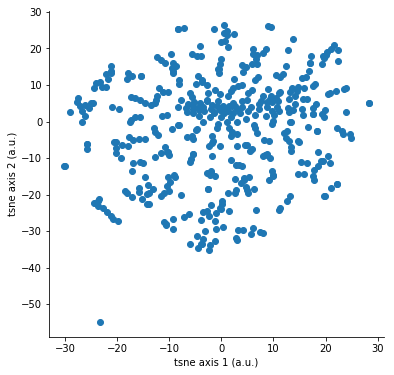

In [25]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
plt.scatter(X_embedded[:,0], X_embedded[:,1])

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('tsne axis 1 (a.u.)')
ax.set_ylabel('tsne axis 2 (a.u.)')

plt.savefig('output/general_clusters.png')

In [19]:
pca = PCA(n_components=50)
X_embedded = TSNE().fit_transform(pca.fit_transform(X))

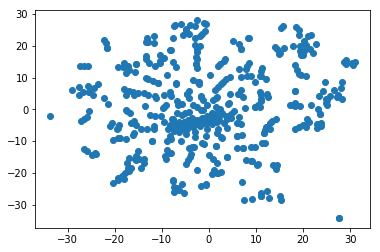

In [20]:
plt.scatter(X_embedded[:,0], X_embedded[:,1])

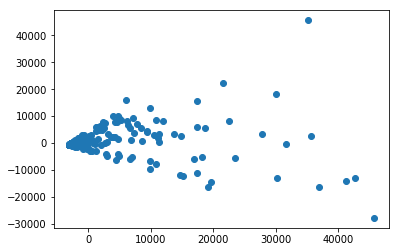

In [21]:
X_tr = pca.fit_transform(X)
plt.scatter(X_tr[:,0],X_tr[:,1])

In [225]:
# DBSCAN
from sklearn.cluster import DBSCAN

pca = PCA(n_components=20)
X_tr = pca.fit_transform(X_stand)
db = DBSCAN(eps=5, min_samples=2)
db.fit(X_tr)

DBSCAN(algorithm='auto', eps=5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=2, n_jobs=None, p=None)

In [226]:
np.unique(db.labels_)

array([-1,  0,  1])

In [229]:
X_embedded = TSNE().fit_transform(X)

In [230]:
# KMEANS
from sklearn.cluster import KMeans

km = KMeans()
km.fit(X_stand)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

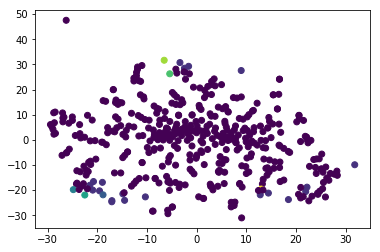

In [231]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=km.labels_)

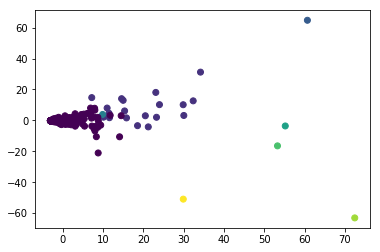

In [232]:
plt.scatter(X_tr[:,0],X_tr[:,1], c=km.labels_)

In [52]:
# 3 Clustering passes: class 1, class 2, intersection(class 1 and class 2)
# Let's look at the intersection of the patients with values on both classes of assay



In [53]:
X.shape

(438, 322)

In [15]:
# Get the tdif array, we use days as seconds will lead to too small values upon division
patient_ts = a
tdif = np.array([float(x.days) for x in patient_ts.index[1:]-patient_ts.index[:-1]]).reshape(-1,1)
# get the differential values for the
vdif = patient_ts.as_matrix()[1:,:]-patient_ts.as_matrix()[:-1,:]

## 19.2.19
### New tests with DTW

Idea: compute dtw between __regularly__ sampled time-series across all channels and use that as a vector embedding for downstream clustering.

The regularly sampled ts condition is enforced using linear interpolation.

In [201]:
# 0. Save the collected timeseries to disk
for patid in list(ts_dict.keys()):
    if ts_dict[patid].isna().sum().sum() >0:
        print(patid)
    ts_dict[patid].to_csv('data/timeseries/class_1/original/{}.csv'.format(patid), na_rep=499)

print()
for patid in list(ts_dict_2.keys()):
    if ts_dict_2[patid].isna().sum().sum() >0:
        print(patid)
    ts_dict_2[patid].to_csv('data/timeseries/class_2/original/{}.csv'.format(patid), na_rep=499) # replace missing values by 499
    

In [127]:
# Reload df with missing entries
for patid in ['RS-XXXXXXX', 'RS-XXXXXXX']: # insert RS of interest here.
    ts_dict[patid] = pd.read_csv('data/timeseries/class_1/original/{}.csv'.format(patid),
                                 index_col=0, parse_dates=True)
for patid in ['RS-XXXXXXX']:# insert RS of interest here.
    ts_dict_2[patid] = pd.read_csv('data/timeseries/class_2/original/{}.csv'.format(patid),
                                 index_col=0, parse_dates=True)
    

In [149]:
# 1. First, get timeseries for each patient and get regularly sampled timeseries
from math import gcd
from functools import reduce

def to_regularly_sampled_ts(df_ts):
    # This function returns a time series with linearly interpolated values at equally sampled timepoints
    # Start by getting the greatest common divisor
    diffs = np.array([int(x.days) for x in df_ts.index[1:]-df_ts.index[:-1]])
    ts = df_ts.as_matrix()
    if len(diffs) > 2:
        d = reduce(lambda x,y: gcd(x,y), diffs)
    elif len(diffs) == 2:
        d = gcd(diffs[0],diffs[1])
    else:
        return ts
    # Do the linear interpolation using numpy
    timeline = np.append([0], np.cumsum(diffs))
    measured_points = np.arange(start=timeline[0], stop=timeline[-1]+1, step=d)
    # Interpolate
    interpolated_ts = np.asarray([np.interp(measured_points, timeline, x) for x in ts.T])
    
    # CAREFUL, THE INTERPOLATION TRANSPOSES THE MATRIX
    return interpolated_ts.T


In [198]:
# After discussing with Jakob (22.2.19), realized it could be beneficial to only linearly interpolate for decay
# while keeping a step function for increases (up to t-1: same value as before)
def to_regularly_sampled_ts_stepup(df_ts):
    # This function returns a time series with linearly interpolated values at equally sampled timepoints
    # and step function for increases in values.
    # Start by getting the greatest common divisor
    diffs = np.array([int(x.days) for x in df_ts.index[1:]-df_ts.index[:-1]])
    ts = df_ts.as_matrix()
    if len(diffs) > 2:
        d = reduce(lambda x,y: gcd(x,y), diffs)
    elif len(diffs) == 2:
        d = gcd(diffs[0],diffs[1])
    else:
        return ts
    # Do the linear interpolation using numpy
    timeline = np.append([0], np.cumsum(diffs))
    measured_points = np.arange(start=timeline[0], stop=timeline[-1]+1, step=d)
    # Interpolate, for each pair of values, check the whether it goes up or down
    interpolated_ts = None
    for i in range(len(diffs)):
        interp_part = []
        for ab in range(ts.shape[1]):
            v0, v1 = ts[i,ab], ts[i+1,ab]
            interp_part.append(interp(v0, v1, int(diffs[i]/d), step=v1>v0))
        if interpolated_ts is None:
            interpolated_ts = np.asarray(interp_part)
        else:
            interpolated_ts = np.hstack([interpolated_ts, np.asarray(interp_part)])
    # Add last values 
    interpolated_ts = np.hstack([interpolated_ts, ts[-1,:].reshape(-1,1)])
    # CAREFUL, THE INTERPOLATION TRANSPOSES THE MATRIX
    return interpolated_ts.T

def interp(val0, val1, n, step=False):
    # Always omit the last value
    if step:
        return np.append([val0 for i in range(n)],[val1])[:-1]
    else:
        return np.interp(np.arange(n+1), [0, n], [val0,val1])[:-1]

In [204]:
# 2. Generate equally-spaced ts for every patient
new_ts_dict = dict()
new_ts_dict_step = dict()
for patid in list(ts_dict.keys()):
    new_ts_dict[patid] = to_regularly_sampled_ts(ts_dict[patid])
    new_ts_dict_step[patid] = to_regularly_sampled_ts_stepup(ts_dict[patid])
    
new_ts_dict_2 = dict()
new_ts_dict_step_2 = dict()
for patid in list(ts_dict_2.keys()):
    new_ts_dict_2[patid] = to_regularly_sampled_ts(ts_dict_2[patid])
    new_ts_dict_step_2[patid] = to_regularly_sampled_ts_stepup(ts_dict_2[patid])

(80, 1090)
(80, 359)
(80, 369)
(80, 189)
(80, 177)
(80, 112)
(80, 2296)
(80, 532)
(80, 672)
(80, 171)
(80, 4)
(80, 1379)
(80, 379)
(80, 104)
(80, 483)
(80, 441)
(80, 821)
(80, 1262)
(80, 1121)
(80, 227)
(80, 1348)
(80, 8)
(80, 61)
(80, 196)
(80, 52)
(80, 317)
(80, 184)
(80, 149)
(80, 333)
(80, 686)
(80, 91)
(80, 343)
(80, 21)
(80, 275)
(80, 89)
(80, 280)
(80, 182)
(80, 84)
(80, 248)
(80, 33)
(80, 58)
(80, 2390)
(80, 157)
(80, 364)
(80, 91)
(80, 612)
(80, 122)
(80, 165)
(80, 287)
(80, 67)
(80, 202)
(80, 269)
(80, 435)
(80, 36)
(80, 133)
(80, 181)
(80, 534)
(80, 1319)
(80, 76)
(80, 351)
(80, 427)
(80, 209)
(80, 274)
(80, 122)
(80, 605)
(80, 45)
(80, 784)
(80, 829)
(80, 112)
(80, 266)
(80, 153)
(80, 531)
(80, 449)
(80, 174)
(80, 316)
(80, 279)
(80, 145)
(80, 182)
(80, 1545)
(80, 32)
(80, 140)
(80, 182)
(80, 184)
(80, 175)
(80, 196)
(80, 390)
(80, 1299)
(80, 102)
(80, 182)
(80, 217)
(80, 191)
(80, 110)
(80, 163)
(80, 42)
(80, 22)
(80, 5)
(80, 1034)
(80, 89)
(80, 119)
(80, 208)
(80, 227)
(8

(80, 44)
(80, 1000)
(80, 69)
(80, 427)
(80, 147)
(80, 201)
(80, 230)
(80, 1074)
(80, 179)
(80, 371)
(80, 203)
(80, 168)
(80, 514)
(80, 27)
(80, 1462)
(80, 32)
(80, 379)
(80, 160)
(80, 392)
(80, 161)
(80, 212)
(80, 1336)
(80, 556)
(80, 902)
(80, 358)
(80, 354)
(80, 98)
(80, 75)
(80, 2343)
(80, 565)
(80, 144)
(80, 709)
(80, 8)
(80, 28)
(80, 85)
(80, 121)
(80, 181)
(80, 68)
(80, 359)
(80, 327)
(80, 56)
(80, 127)
(80, 1118)
(80, 46)
(80, 5)
(80, 51)
(80, 279)
(80, 148)
(80, 237)
(80, 664)
(80, 88)
(80, 226)
(80, 41)
(80, 182)
(80, 97)
(80, 634)
(80, 1)
(80, 11)
(80, 12)
(80, 59)
(80, 42)
(80, 101)
(80, 361)
(80, 722)
(80, 362)
(80, 1445)
(80, 28)
(80, 23)
(80, 51)
(80, 279)
(80, 106)
(80, 385)
(80, 93)
(80, 91)
(80, 184)
(80, 120)
(80, 235)
(80, 358)
(80, 479)
(80, 1192)
(80, 133)
(80, 93)
(80, 91)
(80, 180)
(80, 182)
(80, 679)
(80, 281)
(80, 185)
(80, 120)
(80, 586)
(80, 116)
(80, 185)
(80, 267)
(80, 259)
(80, 105)
(80, 95)
(80, 1027)
(80, 129)
(80, 62)
(80, 116)
(80, 227)
(80, 534)
(80, 

(43, 133)
(43, 45)
(43, 178)
(43, 91)
(43, 91)
(43, 91)
(43, 73)
(43, 346)
(43, 435)
(43, 56)
(43, 491)
(43, 131)
(43, 231)
(43, 362)
(43, 71)
(43, 38)
(43, 109)
(43, 223)
(43, 380)
(43, 603)
(43, 198)
(43, 396)
(43, 318)
(43, 179)
(43, 184)
(43, 201)
(43, 1476)
(43, 70)
(43, 215)
(43, 154)
(43, 275)
(43, 91)
(43, 805)
(43, 345)
(43, 159)
(43, 388)
(43, 216)
(43, 156)
(43, 357)
(43, 1621)
(43, 30)
(43, 19)
(43, 49)
(43, 89)
(43, 275)
(43, 364)
(43, 146)
(43, 297)
(43, 108)
(43, 551)
(43, 350)
(43, 19)
(43, 369)
(43, 37)
(43, 180)
(43, 326)
(43, 543)
(43, 467)
(43, 184)
(43, 182)
(43, 428)
(43, 221)
(43, 1482)
(43, 351)
(43, 510)
(43, 280)
(43, 154)
(43, 119)
(43, 278)
(43, 182)
(43, 98)
(43, 189)
(43, 70)
(43, 2231)
(43, 7)
(43, 7)
(43, 257)
(43, 175)
(43, 51)
(43, 140)
(43, 637)
(43, 752)
(43, 340)
(43, 183)
(43, 209)
(43, 17)
(43, 1501)
(43, 673)
(43, 368)
(43, 1129)
(43, 567)
(43, 237)
(43, 154)
(43, 3128)
(43, 71)
(43, 20)
(43, 91)
(43, 266)
(43, 51)
(43, 286)
(43, 60)
(43, 663)
(4

(43, 267)
(43, 198)
(43, 756)
(43, 106)
(43, 216)
(43, 17)
(43, 339)
(43, 15)
(43, 181)
(43, 384)
(43, 580)
(43, 11)
(43, 177)
(43, 120)
(43, 308)
(43, 298)
(43, 203)
(43, 77)
(43, 14)
(43, 592)
(43, 712)
(43, 365)
(43, 32)
(43, 4)
(43, 21)
(43, 89)
(43, 155)
(43, 70)
(43, 174)
(43, 129)
(43, 18)
(43, 1769)
(43, 149)
(43, 411)
(43, 560)
(43, 53)
(43, 30)
(43, 83)
(43, 23)
(43, 105)
(43, 110)
(43, 238)
(43, 61)
(43, 189)
(43, 250)
(43, 4)
(43, 182)
(43, 184)
(43, 187)
(43, 84)
(43, 641)
(43, 48)
(43, 185)
(43, 285)
(43, 518)
(43, 52)
(43, 259)
(43, 311)
(43, 145)
(43, 378)
(43, 523)
(43, 28)
(43, 447)
(43, 475)
(43, 101)
(43, 295)
(43, 176)
(43, 319)
(43, 891)
(43, 1)
(43, 1)
(43, 2)
(43, 11)
(43, 112)
(43, 123)
(43, 1)
(43, 147)
(43, 148)
(43, 121)
(43, 117)
(43, 183)
(43, 421)
(43, 296)
(43, 187)
(43, 165)
(43, 648)
(43, 59)
(43, 245)
(43, 201)
(43, 52)
(43, 557)
(43, 13)
(43, 140)
(43, 48)
(43, 201)
(43, 35)
(43, 700)
(43, 1923)
(43, 259)
(43, 227)
(43, 3144)
(43, 37)
(43, 161)
(43, 

In [205]:
# Save interpolated ts to disk
np.savetxt('data/timeseries/class_1/patid_interpolated.txt', np.asarray(list(ts_dict.keys())), fmt="%s")
np.savetxt('data/timeseries/class_2/patid_interpolated.txt', np.asarray(list(ts_dict_2.keys())), fmt="%s")
for patid in list(new_ts_dict.keys()):
    np.save('data/timeseries/class_1/interpolated/{}.npy'.format(patid), new_ts_dict[patid])
for patid in list(new_ts_dict_2.keys()):
    np.save('data/timeseries/class_2/interpolated/{}.npy'.format(patid), new_ts_dict_2[patid])
for patid in list(new_ts_dict_step.keys()):
    np.save('data/timeseries/class_1/interpolated_stepup/{}.npy'.format(patid), new_ts_dict_step[patid])
for patid in list(new_ts_dict_step_2.keys()):
    np.save('data/timeseries/class_2/interpolated_stepup/{}.npy'.format(patid), new_ts_dict_step_2[patid])

In [27]:
# 3. Compute DTW for each ts
import tslearn
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans

In [32]:
ts_dataset = to_time_series_dataset(ts_array)

In [49]:
# We set the number of clusters to 5, I tried multiple possibilities
k = 7
seed=42
X = ts_dataset[:,:,0].copy()
# X[np.isnan(X)]=0

km = TimeSeriesKMeans(n_clusters=k, n_init=3, random_state=seed, metric='dtw')
y_pred = km.fit_predict(X)

Init 1


/Users/tomatteo/Library/Python/3.6/lib/python/site-packages/sklearn/metrics/pairwise.py:250: RuntimeWarning: invalid value encountered in maximum
  np.maximum(distances, 0, out=distances)
/Users/tomatteo/Library/Python/3.6/lib/python/site-packages/sklearn/cluster/k_means_.py:122: RuntimeWarning: invalid value encountered in minimum
  distance_to_candidates[trial])


Resumed because of empty cluster
Init 1
Resumed because of empty cluster
Init 1
Resumed because of empty cluster
Init 1


KeyboardInterrupt: 

### Clustering via DTW directly.

In [2]:
# Check DTW clustering results from files (see clsuter_ts.py)
dtw_results = np.load('data/timeseries/class_1/global_dtw_distance_normalization_standard.npy')
patids = np.loadtxt('data/timeseries/class_1/patid_interpolated.txt', dtype=str)

/usr/local/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/usr/local/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


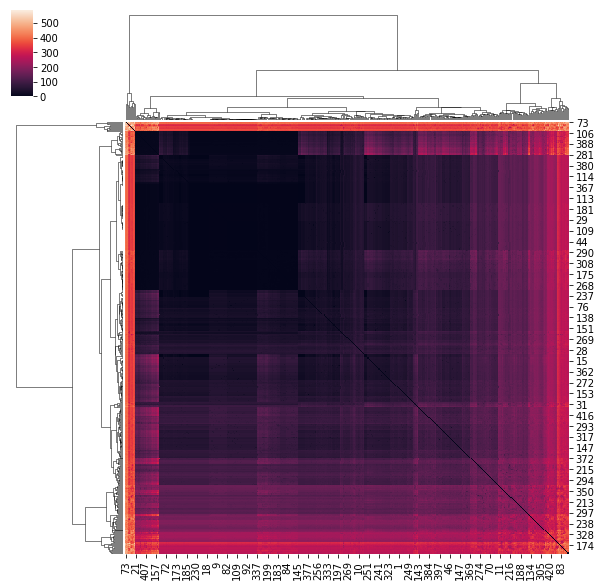

In [3]:
sns.clustermap(dtw_results)

In [5]:
# DTW should not be symmetric but seems to be.
np.allclose(dtw_results, dtw_results.T)

True

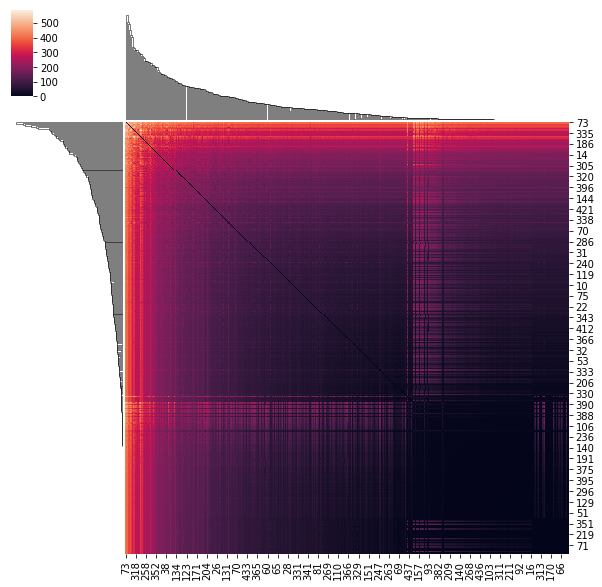

In [310]:
# Cluster using the distance provided by DTW instead
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
# from https://stackoverflow.com/questions/38705359/how-to-give-sns-clustermap-a-precomputed-distance-matrix

# distance matrix
linkage = hc.linkage(sp.distance.squareform(dtw_results), method='single')
sns.clustermap(dtw_results, row_linkage=linkage, col_linkage=linkage)

In [215]:
sp.distance.squareform(dtw_results).shape

(95703,)

In [237]:
# Plot tsne of the patients
from sklearn.manifold import TSNE
np.random.seed(42)
X_embedded = TSNE().fit_transform(dtw_results)

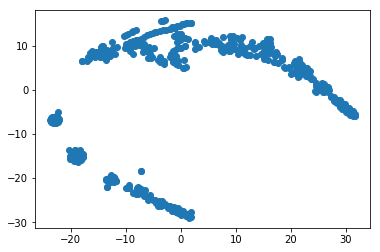

In [238]:
plt.scatter(X_embedded[:,0], X_embedded[:,1])#, c=km.labels_)

In [254]:
# Different color plotting
# With covariate correction: (#age at measurement and gender)
df_map = pd.read_csv("data/RS_nummer_age_sex.csv",index_col=0)
# List of patients, get gender
c_gender = []
sex_dict = {'Female': 0, 'Male': 1}
for patid in patids:
    c_gender.append(sex_dict[df_map.loc[patid,'Sex']])

# For each patient get date of first measurement and date of transplant
yob = []
for patid in patids:
    yob.append(datetime.datetime.strptime(str(df_map.loc[patid, 'Unnamed: 1']), '%Y').year)
# Make colormap for yob
cmap=plt.get_cmap('viridis')

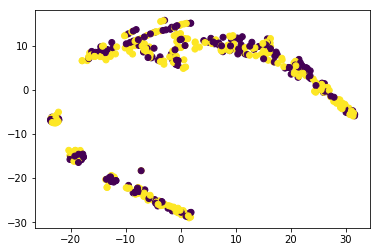

In [7]:
# Gender
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=c_gender)

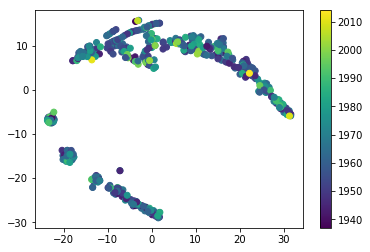

In [8]:
# Year of birth
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=yob, cmap=cmap)

plt.colorbar()

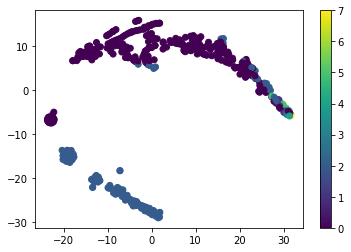

In [44]:
# Hierarchical cluster
from sklearn.cluster import AgglomerativeClustering

clust = AgglomerativeClustering(affinity='precomputed', n_clusters=8, linkage='complete').fit(dtw_results)

plt.scatter(X_embedded[:,0], X_embedded[:,1], c=clust.labels_)
plt.colorbar()

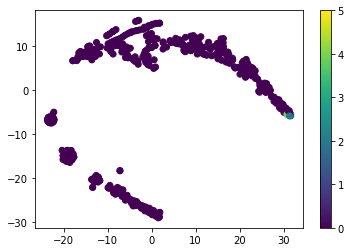

In [89]:
# Spectral cluster
from sklearn.cluster import SpectralClustering

clust = SpectralClustering(affinity='precomputed', n_clusters=6).fit(np.exp(-dtw_results))

plt.scatter(X_embedded[:,0], X_embedded[:,1], c=clust.labels_)
plt.colorbar()

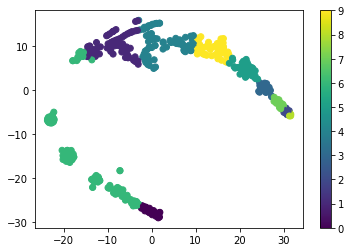

In [54]:
# Spectral cluster
from sklearn.cluster import KMeans

clust = KMeans(n_clusters=10).fit(dtw_results)

plt.scatter(X_embedded[:,0], X_embedded[:,1], c=clust.labels_)
plt.colorbar()

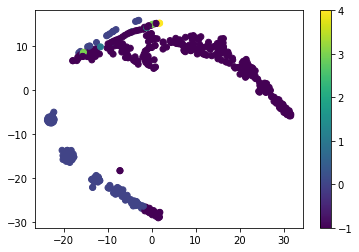

In [81]:
# DBSCAN
from sklearn.cluster import DBSCAN

clust = DBSCAN(eps=5, min_samples=2, metric='precomputed').fit(dtw_results)

plt.scatter(X_embedded[:,0], X_embedded[:,1], c=clust.labels_)
plt.colorbar()

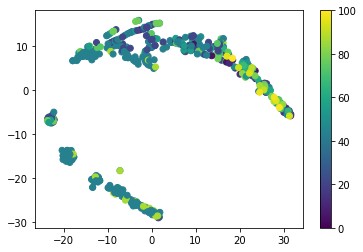

In [87]:
# DBSCAN
from sklearn.cluster import AffinityPropagation

clust = AffinityPropagation(affinity='precomputed', damping=0.99).fit(np.exp(-dtw_results))

plt.scatter(X_embedded[:,0], X_embedded[:,1], c=clust.labels_)
plt.colorbar()

In [85]:
np.unique(clust.labels_).shape

(101,)

In [13]:
# Most risky one: vector length for ts
from utils import get_evolution_df, filter_patients

df_filtered = pd.read_csv('data/MFI_with_RS_new_filtering.csv', encoding = "latin").set_index('RSNR', drop=False)
df_filtered_typ1 = filter_patients(df_filtered)


c_vlen = []
c_duration = []
c_nummeas = []
for patid in patids:
    x = np.load(f'data/timeseries/class_1/interpolated/{patid}.npy')
    c_vlen.append(x.shape[0])
    yob.append(datetime.datetime.strptime(str(df_map.loc[patid, 'Unnamed: 1']), '%Y'))
    patient_ts = get_evolution_df(df_filtered_typ1.loc[patid], complete=True, analysis_type='1')
#     # SKIP MEASUREMENTS TOO CLOSE
#     patient_ts = patient_ts[[x in remove_close_events(patient_ts.index) for x in patient_ts.index]]
    c_nummeas.append(patient_ts.shape[0])
    c_duration.append(np.array((patient_ts.index[-1]-patient_ts.index[0]).days).reshape(-1,1))

/Volumes/tomatteo$/Projects/HLAvariability/utils.py:39: FutureWarning: 'RSNR' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  df_n = df_filtered_typ.groupby('RSNR')['IL_DAT'].nunique()
/Volumes/tomatteo$/Projects/HLAvariability/utils.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered_typ = df_filtered_typ.set_index('RSNR', drop=False)[df_n>1]


17 patients need to be excluded as they only have one date of measurements.


In [19]:
c_duration = np.asarray(c_duration).reshape(-1)

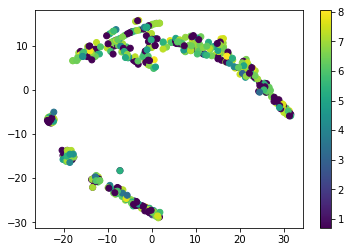

In [14]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=np.log(c_vlen))
plt.colorbar()

In [ ]:
# Good, at least the total diff is not really giving

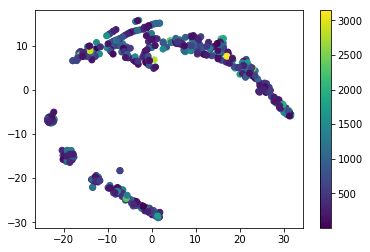

In [22]:
# Duration
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=c_duration)
plt.colorbar()

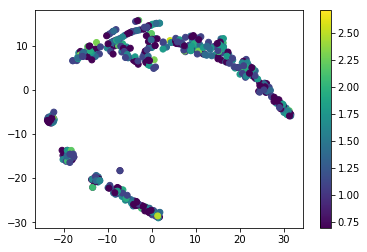

In [25]:
# number of measurements
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=np.log(np.asarray(c_nummeas)))
plt.colorbar()

In [100]:
# Control for immunizing events
# Load the list of transfusions
filename = "data/Transfusions_data_RS_nummer.csv"
df_immunizing = pd.read_csv(filename, encoding = "latin")

# Start by cleaning off the data: RSNR remove asterisks
# Remove lines without RSNR
df_immunizing = df_immunizing[df_immunizing["RSNR"].notnull()]
# Remove asterisks
new_RSNR = []
for rn in df_immunizing['RSNR']:
    if rn[:2] == "**":
        new_RSNR.append(rn[2:-2])
    else:
        new_RSNR.append(rn)

df_immunizing.loc[:,'RSNR'] = new_RSNR

# Now filter and only keep RSNR of interest (i.e. that we kept in the analysis thus far.)
rsnr_of_interest = df_filtered['RSNR'].unique()
print("There are {} entries in the df_immunizing table before filtering".format(df_immunizing.shape[0]))
df_immunizing_filtered = df_immunizing[[d in patids for d in df_immunizing["RSNR"]]]
print("There are {} entries in the df_immunizing table after filtering".format(df_immunizing_filtered.shape[0]))

# 1. most stringent
print(df_immunizing_filtered['TRANSFUSION'].unique())
print(df_immunizing_filtered['SCHWANGERSCHAFT'].unique())
df_strict_filtering = df_immunizing_filtered[np.logical_and(df_immunizing_filtered['TRANSFUSION']=='Nein',
                                                            df_immunizing_filtered['SCHWANGERSCHAFT']=='Nein')]
print("Only {} patients remain after strict filtering.".format(df_strict_filtering.shape[0]))


There are 618 entries in the df_immunizing table before filtering
There are 411 entries in the df_immunizing table after filtering
['Unbekannt' 'Ja' 'Nein' nan]
['Unbekannt' 'Nein' 'Ja' nan]
Only 84 patients remain after strict filtering.


In [110]:
pregnant_ids = list(df_immunizing_filtered.loc[df_immunizing_filtered['SCHWANGERSCHAFT']!='Nein', 'RSNR'])
transfused_ids = list(df_immunizing_filtered.loc[df_immunizing_filtered['SCHWANGERSCHAFT']!='Nein', 'RSNR'])
non_immunized_ids = list(df_strict_filtering.RSNR)

In [111]:
c_immunized = []
c_pregnant = []
c_transfused = []
for patid in patids:
    if patid in pregnant_ids:
        c_pregnant.append(1)
    else:
        c_pregnant.append(0)
    if patid in transfused_ids:
        c_transfused.append(1)
    else:
        c_transfused.append(0)
    if patid in non_immunized_ids:
        c_immunized.append(0)
    else:
        c_immunized.append(1)

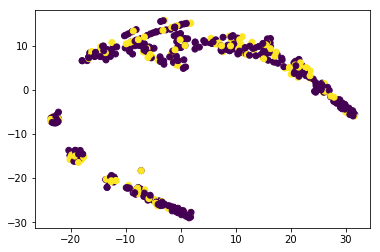

In [112]:
# Pregnancies
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=c_pregnant)

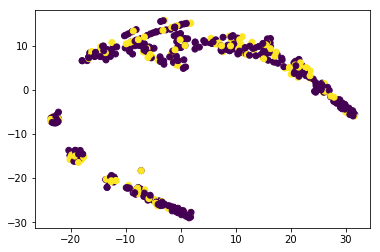

In [113]:
# Transfusions
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=c_transfused)

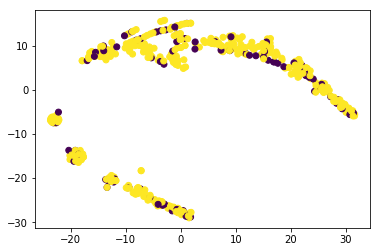

In [114]:
# Pregnancies
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=c_immunized)

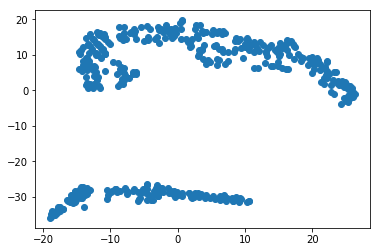

In [96]:
# Plot tsne of the patients
norm_X_embedded = TSNE().fit_transform(norm_dtw)

plt.scatter(norm_X_embedded[:,0], norm_X_embedded[:,1])#, c=km.labels_)

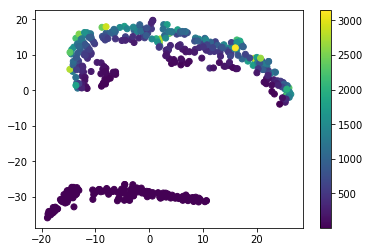

In [97]:
plt.scatter(norm_X_embedded[:,0], norm_X_embedded[:,1], c=c_vlen)
plt.colorbar()

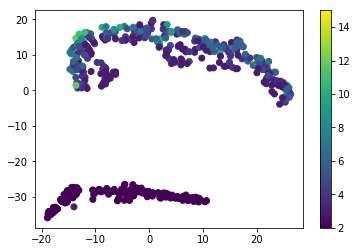

In [99]:
plt.scatter(norm_X_embedded[:,0], norm_X_embedded[:,1], c=c_nummeas)
plt.colorbar()

In [91]:
# PCA
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(dtw_results)

n = 7
print("The top {} parameters explain {:.2f}% of the variance".format(n, 100*pca.explained_variance_ratio_[:n].sum()))

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(dtw_results)
X_stand = scaler.transform(dtw_results)

pca_stand = PCA()
pca_stand.fit(X_stand)

print("The top {} parameters explain {:.2f}% of the variance".format(n, 100*pca_stand.explained_variance_ratio_[:n].sum()))

The top 7 parameters explain 99.00% of the variance
The top 7 parameters explain 97.45% of the variance


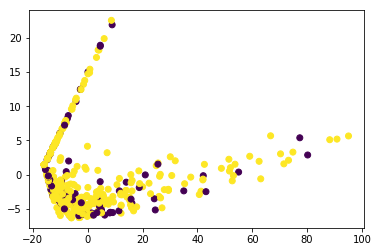

In [115]:
X_tr = pca.fit_transform(X_stand)
plt.scatter(X_tr[:,0],X_tr[:,1], c=c_immunized)

## With new step function

In [207]:
dtw_results_stepup = np.load('data/timeseries/class_1/global_dtw_distance_normalization_standard_stepup_interpolation.npy')


In [222]:
np.allclose(dtw_results, dtw_results_stepup)

False

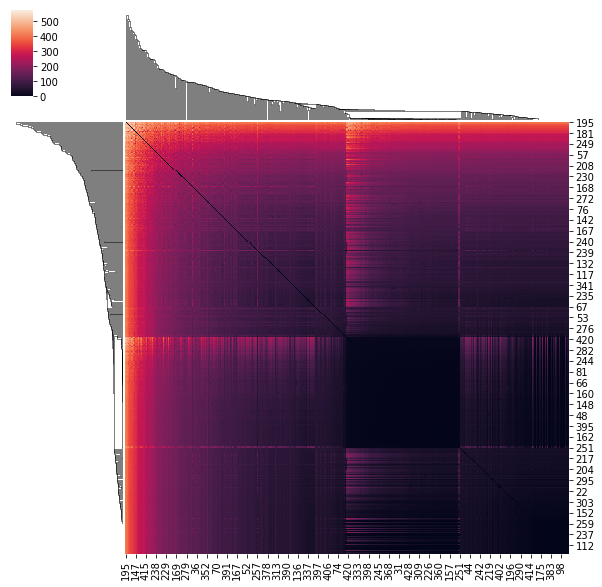

In [223]:
# distance matrix
linkage = hc.linkage(sp.distance.squareform(dtw_results_stepup), method='average')
sns.clustermap(dtw_results_stepup, row_linkage=linkage, col_linkage=linkage)

In [227]:
linkage

array([[ 19.        ,  20.        ,   0.        ,   2.        ],
       [ 35.        , 438.        ,   0.        ,   3.        ],
       [ 68.        , 439.        ,   0.        ,   4.        ],
       ...,
       [100.        , 871.        , 406.85686577, 436.        ],
       [271.        , 872.        , 415.9358619 , 437.        ],
       [195.        , 873.        , 430.4762024 , 438.        ]])

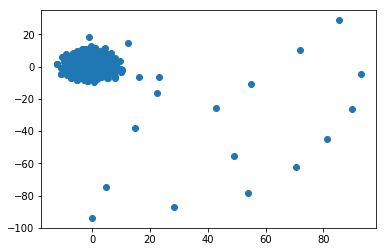

In [247]:
# Plot tsne of the patients
from sklearn.manifold import TSNE
np.random.seed(42)
X_embedded = TSNE(metric='precomputed').fit_transform(dtw_results_stepup)

plt.scatter(X_embedded[:,0], X_embedded[:,1])#, c=km.labels_)

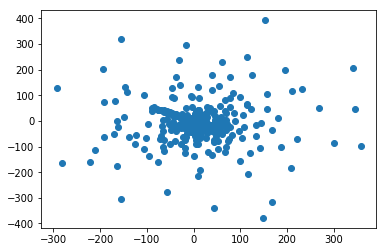

In [301]:
from sklearn.manifold import MDS
X_MDS = MDS(dissimilarity='precomputed').fit_transform(dtw_results_stepup)

plt.scatter(X_MDS[:,0], X_MDS[:,1])

gender
duration
yob
len
n_meas
immunized
pregnant
transfused


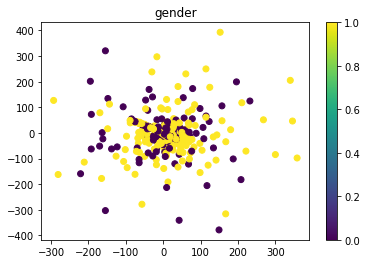

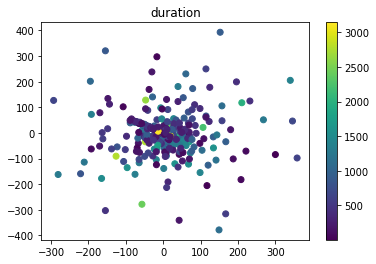

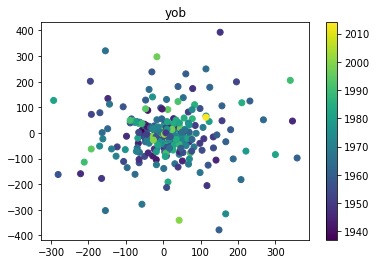

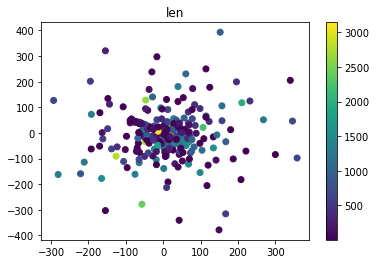

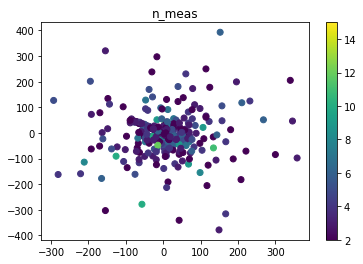

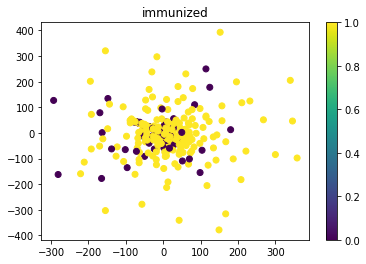

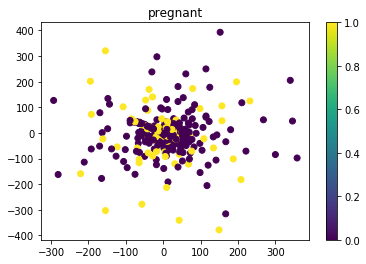

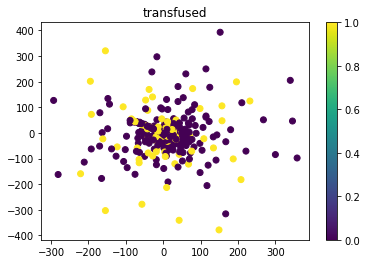

In [302]:
colordict = {'gender': c_gender,'duration':c_duration,
             'yob': yob, 'len': c_vlen, 'n_meas': c_nummeas, 
             'immunized': c_immunized, 'pregnant': c_pregnant, 'transfused': c_transfused
            }

for col in list(colordict.keys()):
    print(col)
    plt.figure()
    plt.scatter(X_MDS[:,0], X_MDS[:,1], c=colordict[col])
    plt.title(col)
    plt.colorbar()

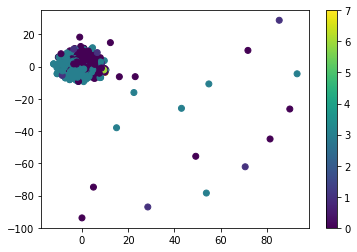

In [283]:
# Hierarchical cluster
from sklearn.cluster import AgglomerativeClustering

clust = AgglomerativeClustering(affinity='precomputed', n_clusters=8, linkage='complete').fit(dtw_results_stepup)

plt.scatter(X_embedded[:,0], X_embedded[:,1], c=clust.labels_)
plt.colorbar()

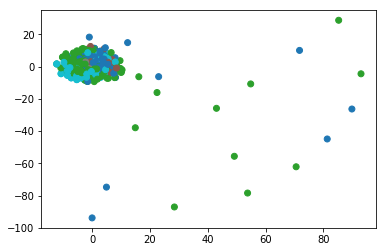

In [300]:
clust = SpectralClustering(affinity='precomputed',n_clusters=5).fit(dtw_results_stepup)
cmap=plt.get_cmap('tab10')
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=clust.labels_, cmap=cmap)

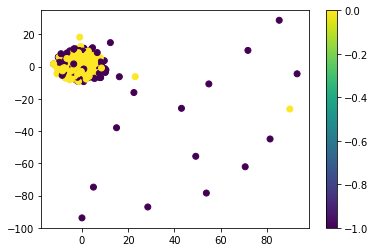

In [293]:
clust = DBSCAN(metric='precomputed', eps=80, min_samples=2).fit(dtw_results_stepup)
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=clust.labels_)
plt.colorbar()